# Linear Elasticity


Linear elasticity is a fundamental theory in mechanics that describes the deformation of solid materials under the influence of external forces. It assumes that the deformation is small and that the relationship between stress and strain is linear. The theory is widely used in various engineering applications, such as structural analysis and material design. FEniCS provides a flexible and efficient platform for implementing finite element methods, making it an excellent choice for solving problems in linear elasticity.


In [180]:
from dolfin import *
from matplotlib import pyplot as plt

In [181]:
length, depth = 3, .300
num_ele_along_depth = 10
ele_size = depth/num_ele_along_depth
mesh = RectangleMesh(Point(0, 0), Point(length, depth),
                     int(length/ele_size), int(depth/ele_size))

## Different spaces in FEniCS

In FEniCS, a "space" is a mathematical construct that contains functions used to approximate the quantities of interest (e.g. displacement, strain, stress, force etc). Different types of function spaces are used depending on the nature of the problem and the type of field variable sought.

| Quantity             | Type                | Function Space      | Dimension |
| -------------------- | ------------------- | ------------------- | --------- |
| Displacement (**u**) | Vector              | VectorFunctionSpace | 2D/3D     |
| Stress               | Second-order tensor | TensorFunctionSpace | 2D/3D     |
| Strain               | Second-order tensor | TensorFunctionSpace | 2D/3D     |
| Von Mises Stress     | Scalar              | FunctionSpace       | 1D        |
| Body Force           | Vector              | VectorFunctionSpace | 2D/3D     |
| Surface Force        | Vector              | VectorFunctionSpace | 2D/3D     |
| Surface Traction     | Second-order tensor | TensorFunctionSpace | 2D/3D     |

Note:

- Von Mises stress is a scalar quantity and is represented using a scalar function space in FEniCS.
- The "Dimension" column still indicates the dimensionality of the problem (2D or 3D).
- The "Type" column specifies the mathematical nature of the quantity (e.g., vector, tensor, scalar).
- The "Function Space" column indicates the corresponding function space to represent the quantity in FEniCS.


In [182]:
V = FunctionSpace(mesh, 'CG', 1)
U = VectorFunctionSpace(mesh, 'CG', 1)
T0 = TensorFunctionSpace(mesh, 'DG', 0)

In [183]:
dim = mesh.topology().dim()

In [184]:
clamped_boundary = CompiledSubDomain("near(x[0],0)")
bc = DirichletBC(U, Constant((0,)*dim), clamped_boundary)

In [185]:
E, nu = 2e11, 0.3
rho, g = 7800, 9.81

$$
\begin{align}
\sigma &= \lambda\,\hbox{tr}\,(\varepsilon) I + 2\mu\varepsilon,\\
\varepsilon &= \frac{1}{2}\left(\nabla u + (\nabla u)^{\top}\right),
\end{align}
$$


In [186]:
lmbda = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))


def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)


def sigma(u):
    return lmbda*tr(epsilon(u))*Identity(dim) + 2*mu*epsilon(u)

In [187]:
# Define variational problem
u, v = TrialFunction(U), TestFunction(U)

In [188]:
f = Constant((0, -rho*g))

In [189]:
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx

# Compute solution
u = Function(U)
solve(a == L, u, bc)

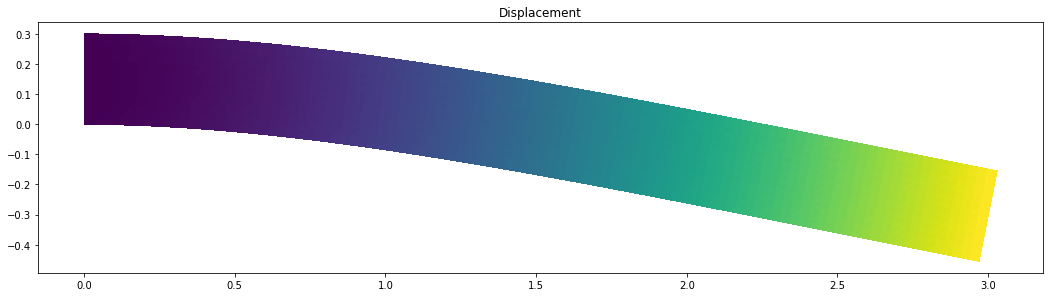

In [190]:
plt.figure(figsize=(18, 16))
# Plot solution
scale_factor = 1000
plot(u*scale_factor, title='Displacement', mode='displacement')

In [191]:
u.vector().min()

-0.0004555058526919105

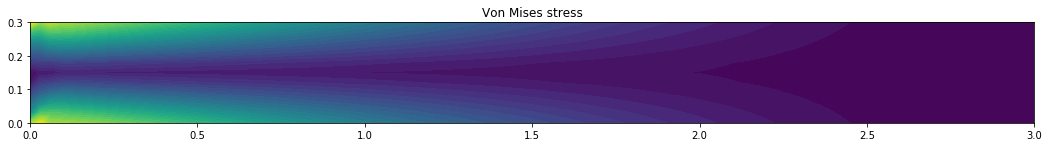

In [192]:
plt.figure(figsize=(18, 16))
# Plot stress
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(dim)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
von_Mises = project(von_Mises, V)
plot(von_Mises, title='Von Mises stress')

min/max u: -2.4213610711295385e-10 0.0004564935128009332


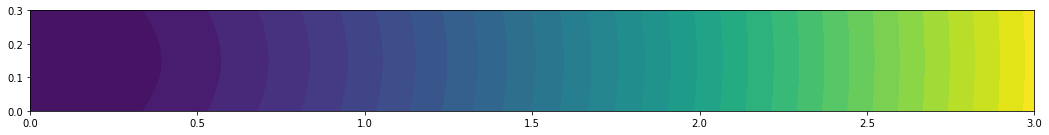

In [193]:
plt.figure(figsize=(18, 16))
# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V)
plot(u_magnitude, 'Displacement magnitude')
print('min/max u:',
      u_magnitude.vector().vec().array.min(),
      u_magnitude.vector().vec().array.max())

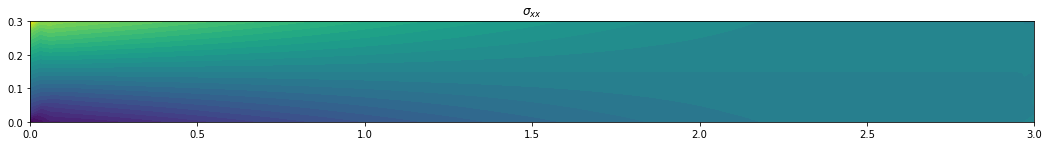

In [194]:
stress = project(sigma(u),T0)
plt.figure(figsize=(18, 16))
plot(stress[0,0], title='$\sigma_{xx}$')

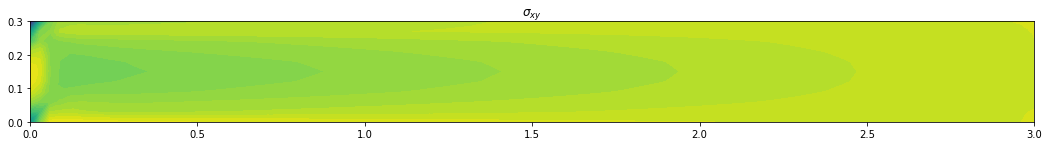

In [195]:
plt.figure(figsize=(18, 16))
plot(stress[0,1], title='$\sigma_{xy}$')

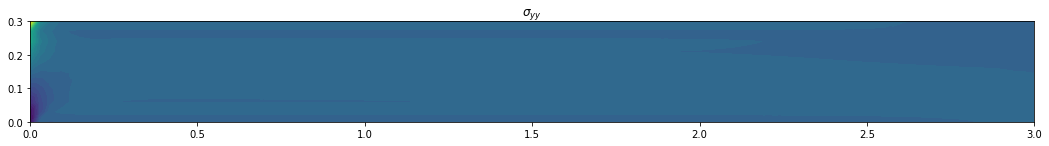

In [196]:
plt.figure(figsize=(18, 16))
plot(stress[1,1], title='$\sigma_{yy}$')